In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *
from read_bricks import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from median_zmag import *
from selection_matrix import * 

In [8]:
# # Reads in data files for use in readData.py

# hdu_sweep1 = fits.open('/Users/mtownsend/Documents/LRG_Data/expanded-data/sweep-140p000-150p005-UVISTA1.fits') # this is one sweep file of the DECaLS data
# hdu_sweep2 = fits.open('/Users/mtownsend/Documents/LRG_Data/expanded-data/sweep-150p000-160p005-UVISTA2.fits') # this is one sweep file of the DECaLS data

# UVISTA1_data = hdu_sweep1[1].data
# UVISTA2_data = hdu_sweep2[1].data

# ra_LS1, dec_LS1, gflux_LS1, rflux_LS1, zflux_LS1, w1flux_LS1, w2flux_LS1, w3flux_LS1, w4flux_LS1, gflux_ivar_LS1, rflux_ivar_LS1, zflux_ivar_LS1, w1flux_ivar_LS1, w2flux_ivar_LS1, w3flux_ivar_LS1, w4flux_ivar_LS1, mw_transmission_g_LS1, mw_transmission_r_LS1, mw_transmission_z_LS1, mw_transmission_w1_LS1, mw_transmission_w2_LS1, mw_transmission_w3_LS1, mw_transmission_w4_LS1 = readBricks(UVISTA1_data)
# ra_LS2, dec_LS2, gflux_LS2, rflux_LS2, zflux_LS2, w1flux_LS2, w2flux_LS2, w3flux_LS2, w4flux_LS2, gflux_ivar_LS2, rflux_ivar_LS2, zflux_ivar_LS2, w1flux_ivar_LS2, w2flux_ivar_LS2, w3flux_ivar_LS2, w4flux_ivar_LS2, mw_transmission_g_LS2, mw_transmission_r_LS2, mw_transmission_z_LS2, mw_transmission_w1_LS2, mw_transmission_w2_LS2, mw_transmission_w3_LS2, mw_transmission_w4_LS2 = readBricks(UVISTA2_data)

# print("end readdata")

# # IMPORTANT NOTE: LRG data is the same for each.

# print(len(ra_LS1) + len(ra_LS2))



hdu_sweep1 = fits.open('/Users/mtownsend/Documents/LRG_Data/expanded-data/sweep-140p000-150p005-UVISTA1.fits') # this is one sweep file of the DECaLS data
hdu_sweep2 = fits.open('/Users/mtownsend/Documents/LRG_Data/expanded-data/sweep-150p000-160p005-UVISTA2.fits') # this is one sweep file of the DECaLS data

UVISTA1_data = hdu_sweep1[1].data
UVISTA2_data = hdu_sweep2[1].data

ra_LS1, dec_LS1, gflux_LS1, rflux_LS1, zflux_LS1, w1flux_LS1, w2flux_LS1, w3flux_LS1, w4flux_LS1, gflux_ivar_LS1, rflux_ivar_LS1, zflux_ivar_LS1, w1flux_ivar_LS1, w2flux_ivar_LS1, w3flux_ivar_LS1, w4flux_ivar_LS1, mw_transmission_g_LS1, mw_transmission_r_LS1, mw_transmission_z_LS1, mw_transmission_w1_LS1, mw_transmission_w2_LS1, mw_transmission_w3_LS1, mw_transmission_w4_LS1 = readBricks(UVISTA1_data)
ra_LS2, dec_LS2, gflux_LS2, rflux_LS2, zflux_LS2, w1flux_LS2, w2flux_LS2, w3flux_LS2, w4flux_LS2, gflux_ivar_LS2, rflux_ivar_LS2, zflux_ivar_LS2, w1flux_ivar_LS2, w2flux_ivar_LS2, w3flux_ivar_LS2, w4flux_ivar_LS2, mw_transmission_g_LS2, mw_transmission_r_LS2, mw_transmission_z_LS2, mw_transmission_w1_LS2, mw_transmission_w2_LS2, mw_transmission_w3_LS2, mw_transmission_w4_LS2 = readBricks(UVISTA2_data)

print("end readdata")

print(len(ra_LS1) + len(ra_LS2))

# 4606780

done reading in DECaLS bricks
done reading in DECaLS bricks
end readdata
3630554


In [9]:
# read in UV data

data_UV = open('/Users/mtownsend/eazy-photoz/inputs/OUTPUT/UVISTA_master_v4.1/UVISTA_final_v4.1.153-155.rf', 'r')
lines_UV = data_UV.readlines()[11:]

z = []
for line in lines_UV:
    p = line.split()
    z.append(float(p[1]))

z = np.array(z)

from astropy.io import ascii
data_cat = data_cat = ascii.read("/Users/mtownsend/eazy-photoz/inputs/UVISTA_master_v4.1.cat")  

ra = data_cat['ra']
dec = data_cat['dec']
# z_spec = data_cat['z_spec']
use = data_cat['USE']
star = data_cat['star']
contamination = data_cat['contamination']
nan_contam = data_cat['nan_contam']
# z = data_cat['z_spec']

cut = np.where((use == 1.) & (star == 0.) & (contamination == 0.) & (nan_contam < 3.)) # & (Uflux > 0.) & (Vflux > 0.) & (zflux > 0.)) # & (zp > 0.))

ra_UV = ra[cut]
dec_UV = dec[cut]
z_peak = z[cut]

print(len(ra_UV))


166641


In [10]:
gmag_LS1 = 22.5 - 2.5 * np.log10(gflux_LS1/mw_transmission_g_LS1)
gmag_LS2 = 22.5 - 2.5 * np.log10(gflux_LS2/mw_transmission_g_LS2)
rmag_LS1 = 22.5 - 2.5 * np.log10(rflux_LS1/mw_transmission_r_LS1)
rmag_LS2 = 22.5 - 2.5 * np.log10(rflux_LS2/mw_transmission_r_LS2)
zmag_LS1 = 22.5 - 2.5 * np.log10(zflux_LS1/mw_transmission_z_LS1)
zmag_LS2 = 22.5 - 2.5 * np.log10(zflux_LS2/mw_transmission_z_LS2)

ra_LS = np.concatenate([ra_LS1, ra_LS2])
dec_LS = np.concatenate([dec_LS1, dec_LS2])
gmag_LS = np.concatenate([gmag_LS1, gmag_LS2])
rmag_LS = np.concatenate([rmag_LS1, rmag_LS2])
zmag_LS = np.concatenate([zmag_LS1, zmag_LS2]) 


# match sources in UVista and LS catalogs

from astropy.coordinates import SkyCoord, match_coordinates_sky                                   
from astropy import units as u       

UVISTA_cat  = SkyCoord(ra=ra_UV*u.degree, dec=dec_UV*u.degree)

my_cat = SkyCoord(ra=ra_LS*u.degree, dec=dec_LS*u.degree) 

idx_UVISTA, sep2d_UVISTA, dist3d_UVISTA = match_coordinates_sky(UVISTA_cat, my_cat, nthneighbor=1)

sep2d_UVISTA_deg = sep2d_UVISTA.deg

sep_idx_UVISTA = idx_UVISTA[np.where(sep2d_UVISTA_deg <= 0.0003)]

print(len(sep_idx_UVISTA))

56710


In [11]:
# # make a new catalog where "medium" bitmasks are not eliminated

# mw_transmission_g = np.concatenate([mw_transmission_g_LS1, mw_transmission_g_LS2])
# mw_transmission_r = np.concatenate([mw_transmission_r_LS1, mw_transmission_r_LS2])
# mw_transmission_z = np.concatenate([mw_transmission_z_LS1, mw_transmission_z_LS2])
# mw_transmission_w1 = np.concatenate([mw_transmission_w1_LS1, mw_transmission_w1_LS2])
# mw_transmission_w2 = np.concatenate([mw_transmission_w2_LS1, mw_transmission_w2_LS2])
# mw_transmission_w3 = np.concatenate([mw_transmission_w3_LS1, mw_transmission_w3_LS2])
# mw_transmission_w4 = np.concatenate([mw_transmission_w4_LS1, mw_transmission_w4_LS2])


# gflux_PRE = np.concatenate([gflux_LS1, gflux_LS2])
# rflux_PRE = np.concatenate([rflux_LS1, rflux_LS2])
# zflux_PRE = np.concatenate([zflux_LS1, zflux_LS2])
# w1flux_PRE = np.concatenate([w1flux_LS1, w1flux_LS2])
# w2flux_PRE = np.concatenate([w2flux_LS1, w2flux_LS2])
# w3flux_PRE = np.concatenate([w3flux_LS1, w3flux_LS2])
# w4flux_PRE = np.concatenate([w4flux_LS1, w4flux_LS2])

# gflux_ivar = np.concatenate([gflux_ivar_LS1, gflux_ivar_LS2])
# rflux_ivar = np.concatenate([rflux_ivar_LS1, rflux_ivar_LS2])
# zflux_ivar = np.concatenate([zflux_ivar_LS1, zflux_ivar_LS2])
# w1flux_ivar = np.concatenate([w1flux_ivar_LS1, w1flux_ivar_LS2])
# w2flux_ivar = np.concatenate([w2flux_ivar_LS1, w2flux_ivar_LS2])
# w3flux_ivar = np.concatenate([w3flux_ivar_LS1, w3flux_ivar_LS2])
# w4flux_ivar = np.concatenate([w4flux_ivar_LS1, w4flux_ivar_LS2])

# g_sigma = []
# g_sigma = 1./np.sqrt(gflux_ivar)

# r_sigma = []
# r_sigma = 1./np.sqrt(rflux_ivar)

# z_sigma = []
# z_sigma = 1./np.sqrt(zflux_ivar)

# w1_sigma = []
# w1_sigma = 1./np.sqrt(w1flux_ivar)

# w2_sigma = []
# w2_sigma = 1./np.sqrt(w2flux_ivar)

# w3_sigma = []
# w3_sigma = 1./np.sqrt(w3flux_ivar)

# w4_sigma = []
# w4_sigma = 1./np.sqrt(w4flux_ivar)

# gflux = gflux_PRE/mw_transmission_g
# rflux = rflux_PRE/mw_transmission_r
# zflux = zflux_PRE/mw_transmission_z
# w1flux = w1flux_PRE/mw_transmission_w1
# w2flux = w2flux_PRE/mw_transmission_w2
# w3flux = w3flux_PRE/mw_transmission_w3
# w4flux = w4flux_PRE/mw_transmission_w4

# print(len(gflux))

# # np.savetxt('/Users/mtownsend/Desktop/LRGphot.cat', np.column_stack([id_LRG1, gflux_LRG1, rflux_LRG1, zflux_LRG1, w1flux_LRG1, w2flux_LRG1, w3flux_LRG1, w4flux_LRG1, gflux_ivar_LRG1, rflux_ivar_LRG1, zflux_ivar_LRG1, w1_ivar_LRG1, w2_ivar_LRG1, w3_ivar_LRG1, w4_ivar_LRG1, z_LRG1]))
# # np.savetxt('/Users/mtownsend/Desktop/LRGphot.cat', np.column_stack([id_LRG, gflux_LRG, rflux_LRG, zflux_LRG, w1flux_LRG, w2flux_LRG, w3flux_LRG, w4flux_LRG, g_sigma, r_sigma, z_sigma, w1_sigma, w2_sigma, w3_sigma, w4_sigma, z_LRG]))




56710
56710
8.649246
-1.876585

5.649908
-0.53150177

22.749905
15.661823
3580


/Users/mtownsend/anaconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


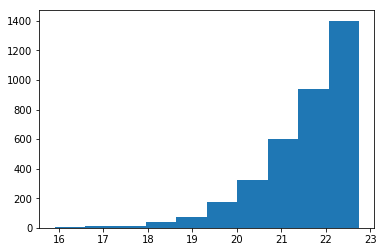

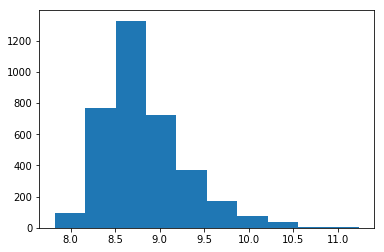

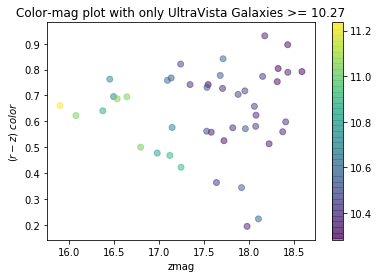

In [47]:
# calculate rest frame g-band luminosity

data_UV = open('/Users/mtownsend/eazy-photoz/inputs/OUTPUT/UV_LS_OUTPUT/UV-LS_main_output.294.rf', 'r')
lines_UV = data_UV.readlines()[10:]

distmod = []
gflux = []
redshift = []
for line in lines_UV:
    p = line.split()
    redshift.append(float(p[1]))
    distmod.append(float(p[2]))
    gflux.append(float(p[5]))

DM = np.array(distmod)
Gflux = np.array(gflux)
zspec = np.array(redshift)

# K correction
K_correct = -2.5*np.log10((1. + zspec)**-1.)

# Absolute magnitude
gMag = -2.5*np.log10(Gflux) + 25. - DM - K_correct

# Calculate rest frame zmag

Msun_z = 4.50
Msun_g = 5.05
gLum = 10.**((gMag-Msun_g)/(-2.5))

log_gLum = np.log10(gLum)

print(len(log_gLum))
print(len(zspec))

# calculate (g-r) and (r-z) colors
    
grcolor_UVLS_nocut = gmag_LS[sep_idx_UVISTA] - rmag_LS[sep_idx_UVISTA]
rzcolor_UVLS_nocut = rmag_LS[sep_idx_UVISTA] - zmag_LS[sep_idx_UVISTA]
zmag_UVLS_nocut = zmag_LS[sep_idx_UVISTA]

grcolor_UVLS = grcolor_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.75) & (np.isnan(log_gLum) == False) & (zspec >= 0.2) & (zspec <= 0.65))]
rzcolor_UVLS = rzcolor_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.75) & (np.isnan(log_gLum) == False) & (zspec >= 0.2) & (zspec <= 0.65))]
zmag_UVLS = zmag_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.75) & (np.isnan(log_gLum) == False) & (zspec >= 0.2) & (zspec <= 0.65))]

zspec_UVLS = zspec[np.where((zmag_UVLS_nocut <= 22.75) & (np.isnan(log_gLum) == False) & (zspec >= 0.2) & (zspec <= 0.65))]

log_gLum_cut = log_gLum[np.where((zmag_UVLS_nocut <= 22.75) & (np.isnan(log_gLum) == False) & (zspec >= 0.2) & (zspec <= 0.65))]


print(grcolor_UVLS.max())
print(grcolor_UVLS.min())
print()
print(rzcolor_UVLS.max())
print(rzcolor_UVLS.min())
print()
print(zmag_UVLS.max())
print(zmag_UVLS.min())

print(len(zmag_UVLS[np.where((zspec_UVLS >= 0.35) & (zspec_UVLS < 0.5))]))

plt.hist(zmag_UVLS[np.where((zspec_UVLS >= 0.35) & (zspec_UVLS < 0.5))])
plt.show()

# plt.hist(zmag_UVLS)
# plt.show()


plt.hist(log_gLum_cut[np.where((zspec_UVLS >= 0.35) & (zspec_UVLS < 0.5))])
plt.show()

plt.scatter(zmag_UVLS[np.where((zspec_UVLS >= 0.35) & (zspec_UVLS < 0.5) & (log_gLum_cut >= 10.27))], rzcolor_UVLS[np.where((zspec_UVLS >= 0.35) & (zspec_UVLS < 0.5) & (log_gLum_cut >= 10.27))], alpha=0.5, c=log_gLum_cut[np.where((zspec_UVLS >= 0.35) & (zspec_UVLS < 0.5) & (log_gLum_cut >= 10.27))], cmap='viridis')
plt.colorbar()
plt.xlabel('zmag')
plt.ylabel('$(r-z)$ $color$')
plt.title('Color-mag plot with only UltraVista Galaxies >= 10.27')
plt.savefig('/Users/mtownsend/Desktop/cmd-UVista-high-lum-complete.pdf')
plt.show()


In [22]:
# rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
# zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.025, 22.025090026855437, 23.025090026855434])
# gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

# rzinit = -1.8027077
# rzfin = 10.44729232788086
# rz_interval = 0.5
# rz_num = (rzfin-rzinit)/rz_interval
# rz_edges, step = np.linspace(rzinit, rzfin, num=int(rz_num), retstep=True)
# print(len(rz_edges))

# grinit = -6.5846786
# grfin = 10.56532135009765
# gr_interval = 0.5
# gr_num = (grfin-grinit)/gr_interval
# gr_edges, step = np.linspace(grinit, grfin, num=int(gr_num), retstep=True)
# print(len(gr_edges))

# zmaginit = 13.
# zmagfin = 23.
# interval = 0.2
# zmag_num = (zmagfin-zmaginit)/interval
# zmag_edges, step = np.linspace(zmaginit, zmagfin, num=int(zmag_num), retstep=True)
# print(type(zmag_edges))

# rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
# rz_edges_new = np.array([-2.6097374,  -2.34501874, -2.08030008, -1.81558142, -1.55086276, -1.2861441, -1.02142544, -0.75670678, -0.49198812, -0.22726946,  0.03744919,  0.30216785, 0.56688651,  0.83160517,  1.09632383,  1.36104249,  1.62576115,  1.89047981, 2.15519847,  2.41991713,  2.68463579,  2.94935444,  3.2140731,   3.47879176, 3.74351042,  4.00822908,  4.27294774,  4.5376664,   4.80238506,  5.06710372, 5.33182238,  5.59654103,  5.86125969,  6.12597835,  6.39069701,  6.65541567, 6.92013433,  7.18485299,  7.44957165,  7.71429031,  7.97900897,  8.24372763, 8.50844628,  8.77316494,  9.0378836,   9.30260226,  9.56732092,  9.83203958, 10.09675824, 10.3614769])
# # zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.025, 22.025090026855437, 23.025090026855434])
# # gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])
# gr_edges = np.array([-6.58467865, -6.21463671, -5.84459476, -5.47455282, -5.10451087, -4.73446893, -4.36442698, -3.99438504, -3.62434309, -3.25430115, -2.8842592,  -2.51421726, -2.14417532, -1.77413337, -1.40409143, -1.03404948, -0.66400754, -0.29396559, 0.07607635,  0.4461183,  0.81616024,  1.18620219,  1.55624413,  1.92628607, 2.29632802,  2.66636996,  3.03641191,  3.40645385,  3.7764958,   4.14653774, 4.51657969,  4.88662163,  5.25666358,  5.62670552,  5.99674746,  6.36678941, 6.73683135,  7.1068733,   7.47691524,  7.84695719,  8.21699913,  8.58704108, 8.95708302,  9.32712497,  9.69716691, 10.06720885, 10.4372508,  10.80729274, 11.17733469, 11.54737663])

# zmaginit = 13.
# zmagfin = 23.
# interval = 0.2
# zmag_num = (zmagfin-zmaginit)/interval
# zmag_edges, step = np.linspace(zmaginit, zmagfin, num=int(zmag_num), retstep=True)
# print(len(zmag_edges))
# print(len(rz_edges))
# print(len(gr_edges))

# rz_edges = np.array([-4.16345787, -3.77797053, -3.39248319, -3.00699584, -2.6215085,  -2.23602116,
#  -1.85053382, -1.46504647, -1.07955913, -0.69407179, -0.30858445,  0.0769029,
#   0.46239024,  0.84787758,  1.23336492,  1.61885227,  2.00433961,  2.38982695,
#   2.77531429,  3.16080163,  3.54628898,  3.93177632,  4.31726366,  4.702751,
#   5.08823835,  5.47372569,  5.85921303,  6.24470037,  6.63018772,  7.01567506,
#   7.4011624,   7.78664974,  8.17213709,  8.55762443,  8.94311177,  9.32859911,
#   9.71408645, 10.0995738,  10.48506114, 10.87054848, 11.25603582, 11.64152317,
#  12.02701051, 12.41249785, 12.79798519, 13.18347254, 13.56895988, 13.95444722,
#  14.33993456, 14.72542191])

# gr_edges = np.array([-11.76210213, -11.13148534, -10.50086854, -9.87025175, -9.23963496,
#   -8.60901817,  -7.97840138,  -7.34778459,  -6.7171678,   -6.086551,
#   -5.45593421,  -4.82531742,  -4.19470063,  -3.56408384,  -2.93346705,
#   -2.30285026,  -1.67223346,  -1.04161667,  -0.41099988,   0.21961691,
#    0.8502337,    1.48085049,   2.11146728,   2.74208407,   3.37270087,
#    4.00331766,   4.63393445,   5.26455124,   5.89516803,   6.52578482,
#    7.15640161,   7.78701841,   8.4176352,    9.04825199,   9.67886878,
#   10.30948557,  10.94010236,  11.57071915,  12.20133595,  12.83195274,
#   13.46256953,  14.09318632,  14.72380311,  15.3544199,   15.98503669,
#   16.61565349,  17.24627028,  17.87688707,  18.50750386,  19.13812065])

# zmag_edges = np.array([ 9.63742733,  9.90809207, 10.17875681, 10.44942155, 10.72008629, 10.99075103,
#  11.26141577, 11.53208051, 11.80274525, 12.07341,    12.34407474, 12.61473948,
#  12.88540422, 13.15606896, 13.4267337,  13.69739844, 13.96806318, 14.23872792,
#  14.50939266, 14.7800574,  15.05072214, 15.32138688, 15.59205162, 15.86271636,
#  16.1333811,  16.40404584, 16.67471059, 16.94537533, 17.21604007, 17.48670481,
#  17.75736955, 18.02803429, 18.29869903, 18.56936377, 18.84002851, 19.11069325,
#  19.38135799, 19.65202273, 19.92268747, 20.19335221, 20.46401695, 20.73468169,
#  21.00534643, 21.27601118, 21.54667592, 21.81734066, 22.0880054,  22.35867014,
#  22.62933488, 22.89999962])

rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
# zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.025, 22.025090026855437, 23.025090026855434])
gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

zmaginit = 13.
zmagfin = 23.
interval = 0.2
zmag_num = (zmagfin-zmaginit)/interval
zmag_edges, step = np.linspace(zmaginit, zmagfin, num=int(zmag_num), retstep=True)
print(type(zmag_edges))
edges = np.array([rz_edges, gr_edges, zmag_edges])
print(edges.shape)

Hstar2D, rz_nouse, gr_nouse = np.histogram2d(rzcolor_UVLS, grcolor_UVLS, bins=(rz_edges, gr_edges), density=False)
Hstar3D, nouse_edges = np.histogramdd((rzcolor_UVLS, grcolor_UVLS, zmag_UVLS), bins=(rz_edges, gr_edges, zmag_edges), density=False)

print(type(Hstar2D))
print(Hstar2D.shape)
print(Hstar3D.shape)

# zinit = 0.2
# zfin = 0.65
# interval = 0.15
# # num = (zfin-zinit)/interval
# num = 4. 
# zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)
# print(zrange)



<class 'numpy.ndarray'>
(3, 50)
<class 'numpy.ndarray'>
(49, 49)
(49, 49, 49)


In [23]:
zinit = 0.2
zfin = 0.65
interval = 0.15
# num = (zfin-zinit)/interval
num = 4. 
zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)
print(zrange)

[0.2  0.35 0.5  0.65]


In [78]:
# rzcolor = rzcolor_UVLS[0:15]
# # print(len(rzcolor))
# grcolor = grcolor_UVLS[0:15]
# zmag = zmag_UVLS[0:15]
# lum1 = log_gLum_cut[0:15]
# zspec = zspec_UVLS[0:15]

# Hstar2D, rz_nouse, gr_nouse = np.histogram2d(rzcolor, grcolor, bins=(2, 2), density=False)
# print(Hstar2D.shape)


# def median_zmag(H2D, lum_limit, lum, x, y, z, xedges, yedges):
#     # For use with selection_matrix.py
#     # lum_limit == log(luminosity threshold)
#     # x,y,z == arrays involved in the 3D histogram
#     # lum = log luminosity array; same size as x (or y or z)
#     # xedges,yedges = boundaries to search for x,y

#     import numpy as np

#     temp = []
#     medzmag = np.full_like(H2D, -999., dtype=float)

#     # This loop finds the observed zmag that cooresponds to the luminosity limit for each cell in color-color space
#     for i in range(len(xedges) - 1):
#         for j in range(len(yedges) - 1):
#             for m in range(len(x)):
#                 if ((x[m] >= xedges[i]) & (x[m] <= xedges[i + 1]) & (y[m] >= yedges[j]) & (y[m] <= yedges[j + 1])):
#                     if (abs(lum[m] - lum_limit) < 0.2):
#                         temp.append(z[m])
#                         print(lum[m])
#                         print(z[m])
#                         print(x[m])
#                         print(y[m])
#                         print(m)
#                         print('gals')
#                         print()
#                     if (len(temp) > 0.):
#                         medzmag[i][j] = np.median(list(temp))
# #                         print(medzmag[i][j])
# #                         print()
#                     else:
#                         print(m)
#                         print('no gals')
#                         print()
#                 else:
#                     print(m)
#                     print('no gals in cell')
#                     print()
#         print(medzmag)
#         print()
#         temp = []

#     return medzmag


# # medianzmag = [] 
# # for i in range(len(zrange)-1):
# x1 = rzcolor #[np.where((zspec > zrange[0]) & (zspec <= zrange[1]))]
# y1 = grcolor #[np.where((zspec > zrange[0]) & (zspec <= zrange[1]))]
# z1 = zmag #[np.where((zspec > zrange[0]) & (zspec <= zrange[1]))]
# lum1 = log_gLum_cut #[np.where((zspec > zrange[i]) & (zspec <= zrange[1]))]
# medzmag = median_zmag(Hstar2D, 9.5, lum1, x1, y1, z1, rz_nouse, gr_nouse)
# # medzmag = median_zmag(Hstar2D, 9.93, lum1, x1, y1, z1, rz_nouse, gr_nouse)
# # medzmag = median_zmag(Hstar2D, 10.27, lum1, x1, y1, z1, rz_nouse, gr_nouse)
# medianzmag.append(medzmag)


In [50]:
print(np.array(medianzmag).shape)
print(medianzmag[2])

(3, 2, 2)
[[  19.78826332 -999.        ]
 [-999.         -999.        ]]


In [24]:
from median_zmag import *

medianzmag_slice = []
medianzmag_upto = []
medianzmag = [] 
for i in range(len(zrange)-1):
    x1 = rzcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     x2 = rzcolor_UVLS[np.where(zspec_UVLS <= zrange[i+1])]
#     print(len(x))
    y1 = grcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     y2 = grcolor_UVLS[np.where(zspec_UVLS <= zrange[i+1])]
#     print(len(y))
    z1 = zmag_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     z2 = zmag_UVLS[np.where(zspec_UVLS <= zrange[i+1])]
#     print(len(z))
    lum1 = log_gLum_cut[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     lum2 = log_gLum_cut[np.where(zspec_UVLS <= zrange[i+1])]
#     print(len(lum))
#     medzmag = median_zmag(Hstar2D, 9.5, lum1, x1, y1, z1, rz_edges, gr_edges)
#     medzmag = median_zmag(Hstar2D, 9.93, lum1, x1, y1, z1, rz_edges, gr_edges)
    medzmag = median_zmag(Hstar2D, 10.27, lum1, x1, y1, z1, rz_edges, gr_edges)
    medianzmag.append(medzmag)
#     medianzmag_upto.append(medzmag_upto)
    print(i)
    
# medzmag_high= median_zmag(Hstar2D, 10.46, log_gLum_cut, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, rz_edges_new, gr_edges)
# medzmag_low = median_zmag(Hstar2D, 9.7, log_gLum_cut, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, rz_edges_new, gr_edges)
# medzmag_mid1 = median_zmag(Hstar2D, 9.84, log_gLum_cut, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, rz_edges_new, gr_edges)
# medzmag_mid2 = median_zmag(Hstar2D, 10.24, log_gLum_cut, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, rz_edges_new, gr_edges)

print(np.asarray(medianzmag).shape)


0
1
2
(3, 49, 49)


In [96]:
zmag = np.array([medianzmag])
print(zmag[np.where(zmag != -999)])

# [19.6263752  19.6263752  19.6263752  19.6263752  19.15280914 19.48984528
#  19.49839592 19.49839592 19.49839592 18.52420235 19.17953873 19.2370224
#  19.2370224  19.2370224  19.2370224  19.2370224  19.23126602 19.20324707
#  19.21115875 19.20324707 19.2366581  18.94975853 18.94975853 18.94975853
#  18.94975853]

[19.6263752  19.6263752  19.6263752  19.6263752  19.15280914 19.48984528
 19.49839592 19.49839592 19.49839592 18.52420235 19.17953873 19.2370224
 19.2370224  19.2370224  19.2370224  19.2370224  19.23126602 19.20324707
 19.21115875 19.20324707 19.2366581  18.94975853 18.94975853 18.94975853
 18.94975853]


In [25]:
np.savez('/Users/mtownsend/Desktop/highz_medzmag-3matrices-EDR-new.npz', medzmag=medianzmag)

# data_zmag_low = np.load('/Users/mtownsend/Desktop/highz_medzmag-3matrices-EDR-new.npz')
# zmag_low = data_zmag_low['medzmag']
# print(zmag_low.shape)

# zmag_low0 = zmag_low[0]

# print(zmag_low0[np.where(zmag_low0 != -999)])
# print()
# print()


# # # print(np.asarray(medianzmag).shape)
# data_zmag_mid = np.load('/Users/mtownsend/Desktop/midz_medzmag-2matrices-EDR.npz')
# zmag_mid = data_zmag_mid['medzmag']
# # print(zmag.shape)

# zmag_mid0 = zmag_mid[0]
# zmag_mid1 = zmag_mid[1]
# # zmag2 = zmag[2]

# print(zmag_mid0[np.where(zmag_mid0 != -999)])
# print()
# print(zmag_mid1[np.where(zmag_mid1 != -999)])
# print()
# print()

# print(np.asarray(medianzmag).shape)
data_zmag_high = np.load('/Users/mtownsend/Desktop/highz_medzmag-3matrices-EDR-new.npz')
zmag_high = data_zmag_high['medzmag']
# print(zmag.shape)

zmag_high0 = zmag_high[0]
zmag_high1 = zmag_high[1]
zmag_high2 = zmag_high[2]

print(zmag_high0[np.where(zmag_high0 != -999)])
print()
print(zmag_high1[np.where(zmag_high1 != -999)])
print()
print(zmag_high2[np.where(zmag_high2 != -999)])



[18.2921257  18.2921257  18.2921257  18.2921257  18.2921257  17.91418076
 17.72453308 17.72453308 17.72453308 17.72453308 17.72453308 17.72453308
 17.40911102 17.40911102 17.40911102 17.40911102]

[17.98057938 17.98057938 17.98057938 17.98057938 18.64965439 18.64965439
 18.64965439 18.64965439 18.02291679 18.20026779 18.26691437 18.26691437
 18.26691437 18.17865372 18.15319061 18.1813488  18.1813488  18.35206604
 18.35206604 18.35206604 18.35206604 18.35206604]

[20.01962852 20.01962852 20.01962852 20.01962852 19.7512207  19.62475967
 19.62475967 19.62475967 19.62475967 19.30361938 19.40545273 19.43193436
 19.43193436 19.43193436 19.43193436 19.43193436 19.1518898  19.1518898
 19.1518898  19.37701416 19.24058151 19.26774979 19.27820206 19.27820206
 19.50788116 19.47363663 19.34315681 19.3912735  19.3912735  19.3912735
 19.52955627 19.5782032  19.54856873 19.54856873 19.54856873 19.54856873
 19.54856873 19.06716537 19.06716537 19.06716537 19.7404232  19.66714478
 19.66714478 19.66714478

In [27]:
smatrix_upto = []
smatrix_slice = []
smatrix = []
for i in range(len(zmag_high)):
    masks = selection_matrix(Hstar3D, zmag_high[i], zmag_edges)
    smatrix.append(masks)
    print(i)


# smatrix_high = selection_matrix(Hstar3D, medzmag_high, zmag_edges)
# smatrix_low = selection_matrix(Hstar3D, medzmag_low, zmag_edges)
# smatrix_mid1 = selection_matrix(Hstar3D, medzmag_mid1, zmag_edges)
# smatrix_mid2 = selection_matrix(Hstar3D, medzmag_mid2, zmag_edges)

print(np.asarray(smatrix).shape)

0
1
2
(3, 49, 49, 49)


In [29]:
np.savez('/Users/mtownsend/Desktop/highz_smatrix-3matrices-EDR-new.npz', smatrix=smatrix)

# print(np.asarray(smatrix).shape)
data_smatrix = np.load('/Users/mtownsend/Desktop/highz_smatrix-3matrices-EDR-new.npz')
smatrix = data_smatrix['smatrix']
print(smatrix.shape)

(3, 49, 49, 49)


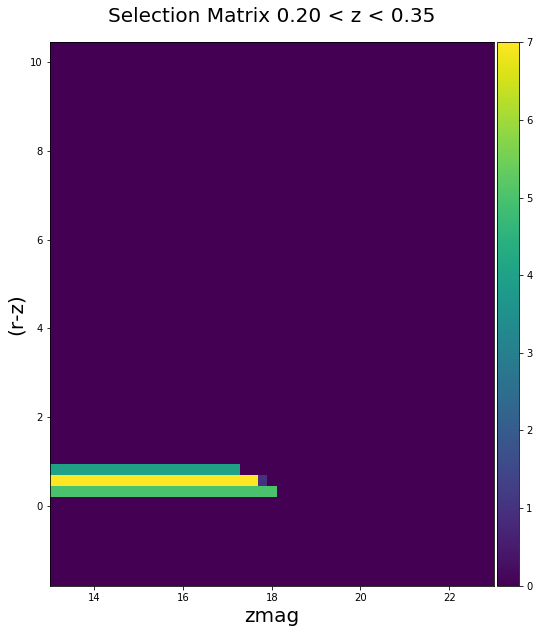

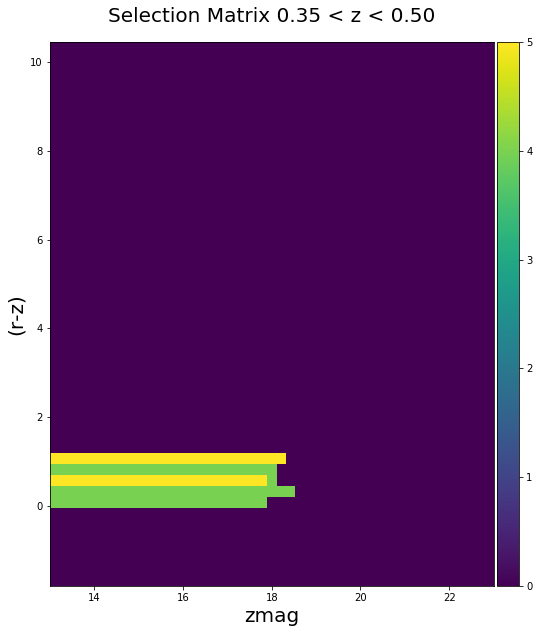

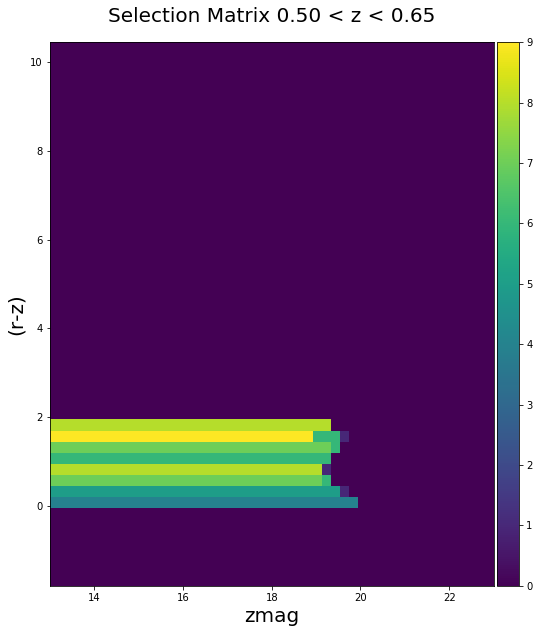

In [30]:
# data_smatrix = np.load('/Users/mtownsend/Desktop/highz_smatrix-3matrices-newbins.npz')
# data_smatrix_og = np.load('/Users/mtownsend/Desktop/highz_smatrix-3matrices-v2.npz')
data_smatrix = np.load('/Users/mtownsend/Desktop/highz_smatrix-3matrices-EDR-new.npz')


# print(data_smatrix)

mask = data_smatrix['smatrix']
mask0 = mask[0]
mask1 = mask[1]
mask2 = mask[2]
# mask1 = data_smatrix['smatrix1']
# mask2 = data_smatrix['smatrix2']
# mask3 = data_smatrix['smatrix3']
# mask4 = data_smatrix['smatrix4']

# mask_og = data_smatrix_og['smatrix']
# # print(mask_og.shape)
# mask0_og = mask_og[0]
# mask1_og = mask_og[1]
# mask2_og = mask_og[2]

# print(mask0.shape)
# print(mask1.shape)
# print(mask2.shape)

# mega_mask = mask0 + mask1 + mask2 + mask3 + mask4

projectionMask0 = mask0[:, :, :].sum(axis=1)
projectionMask1 = mask1[:, :, :].sum(axis=1)
projectionMask2 = mask2[:, :, :].sum(axis=1)
# projectionMask3 = mask3[:, :, :].sum(axis=2)
# projectionMask4 = mask4[:, :, :].sum(axis=2)

# projectionMask0_og = mask0_og[:, :, :].sum(axis=2)
# projectionMask1_og = mask1_og[:, :, :].sum(axis=2)
# projectionMask2_og = mask2_og[:, :, :].sum(axis=2)


# print(projectionMask0.shape)
# print(projectionMask1.shape)
# print(projectionMask2.shape)

# projectionMegaMask = mega_mask[:, :, :].sum(axis=2)

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(projectionMask0, origin='lower', extent=(zmag_edges.min(), zmag_edges.max(), rz_edges.min(), rz_edges.max()))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Selection Matrix {0:.2f} < z < {1:.2f}".format(zrange[0], zrange[1]), fontsize=20, pad=20)
# ax.set_title("Selection Matrix", fontsize=20, pad=20)
ax.set_xlabel('zmag',fontsize=20)
ax.set_ylabel('(r-z)',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/low-z-selection_matrix_{0:.2f}-{1:.2f}.pdf'.format(zrange[4], zrange[5]))   
plt.show()

# plt.figure(figsize=(10,10))
# ax = plt.gca()
# im = ax.imshow(projectionMask0_og, origin='lower') #, extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(im, cax=cax)
# ax.set_title("Selection Matrix {0:.2f} < z < {1:.2f}".format(zrange[0], zrange[1]), fontsize=20, pad=20)
# # ax.set_title("Selection Matrix", fontsize=20, pad=20)
# ax.set_xlabel('(g-r)',fontsize=20)
# ax.set_ylabel('(r-z)',fontsize=20)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/low-z-selection_matrix_{0:.2f}-{1:.2f}.pdf'.format(zrange[4], zrange[5]))   
# plt.show()

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(projectionMask1, origin='lower', extent=(zmag_edges.min(), zmag_edges.max(), rz_edges.min(), rz_edges.max()))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Selection Matrix {0:.2f} < z < {1:.2f}".format(zrange[1], zrange[2]), fontsize=20, pad=20)
# ax.set_title("Selection Matrix", fontsize=20, pad=20)
ax.set_xlabel('zmag',fontsize=20)
ax.set_ylabel('(r-z)',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/low-z-selection_matrix_{0:.2f}-{1:.2f}.pdf'.format(zrange[4], zrange[5]))   
plt.show()

# plt.figure(figsize=(10,10))
# ax = plt.gca()
# im = ax.imshow(projectionMask1_og, origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(im, cax=cax)
# ax.set_title("Selection Matrix {0:.2f} < z < {1:.2f}".format(zrange[1], zrange[2]), fontsize=20, pad=20)
# # ax.set_title("Selection Matrix", fontsize=20, pad=20)
# ax.set_xlabel('(g-r)',fontsize=20)
# ax.set_ylabel('(r-z)',fontsize=20)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/low-z-selection_matrix_{0:.2f}-{1:.2f}.pdf'.format(zrange[4], zrange[5]))   
# plt.show()

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(projectionMask2, origin='lower', extent=(zmag_edges.min(), zmag_edges.max(), rz_edges.min(), rz_edges.max()))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Selection Matrix {0:.2f} < z < {1:.2f}".format(zrange[2], zrange[3]), fontsize=20, pad=20)
# ax.set_title("Selection Matrix", fontsize=20, pad=20)
ax.set_xlabel('zmag',fontsize=20)
ax.set_ylabel('(r-z)',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/low-z-selection_matrix_{0:.2f}-{1:.2f}.pdf'.format(zrange[4], zrange[5]))   
plt.show()

# plt.figure(figsize=(10,10))
# ax = plt.gca()
# im = ax.imshow(projectionMask2_og, origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(im, cax=cax)
# ax.set_title("Selection Matrix {0:.2f} < z < {1:.2f}".format(zrange[1], zrange[2]), fontsize=20, pad=20)
# # ax.set_title("Selection Matrix", fontsize=20, pad=20)
# ax.set_xlabel('(g-r)',fontsize=20)
# ax.set_ylabel('(r-z)',fontsize=20)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/low-z-selection_matrix_{0:.2f}-{1:.2f}.pdf'.format(zrange[4], zrange[5]))   
# plt.show()
